# Predicting Houses by Region

## Imports

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, invgamma
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Dataset

In [13]:
data = pd.read_csv('After_feature_engineering.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Suburb                           13148 non-null  object 
 1   Address                          13148 non-null  object 
 2   Rooms                            13148 non-null  int64  
 3   Type                             13148 non-null  object 
 4   Price                            13148 non-null  float64
 5   SellerG                          13148 non-null  object 
 6   Date                             13148 non-null  object 
 7   Distance                         13148 non-null  float64
 8   Postcode                         13148 non-null  int64  
 9   Bedroom2                         13148 non-null  int64  
 10  Bathroom                         13148 non-null  int64  
 11  Car                              13148 non-null  int64  
 12  Landsize          

In [19]:
# Create a pivot table to count properties sold per region per year
year_region_counts = data.pivot_table(
    index='Regionname', 
    columns='YearSold', 
    values='Price',  # Using 'Price' since it exists and counts rows effectively
    aggfunc='count',
    fill_value=0
).reset_index()

# Display the DataFrame
print(year_region_counts)

YearSold                  Regionname  2016  2017
0               Eastern Metropolitan   474   953
1                   Eastern Victoria     0    47
2              Northern Metropolitan  1844  1919
3                  Northern Victoria     0    34
4         South-Eastern Metropolitan    24   416
5              Southern Metropolitan  2498  2015
6               Western Metropolitan  1385  1508
7                   Western Victoria     0    31


This means that we can't split the data by YearSold as 3 out of 8 regions have 0 houses sold in 2016.

## Model per Region

### Likelihood Function

In [14]:
# Likelihood Function
def log_likelihood(y, X, beta, sigma2):
    n = len(y)
    mu = np.dot(X, beta)  # Predicted mean
    residuals = y - mu
    return -0.5 * n * np.log(2 * np.pi * sigma2) - np.sum(residuals ** 2) / (2 * sigma2)

# Prior for beta (Normal)
def log_prior_beta(beta):
    return np.sum(norm.logpdf(beta, loc=0, scale=10))  # Mean=0, Var=10^2

# Prior for sigma2 (Inverse-Gamma)
def log_prior_sigma2(sigma2):
    return invgamma.logpdf(sigma2, a=2, scale=1)

# Posterior Function
def log_posterior(y, X, beta, sigma2):
    return log_likelihood(y, X, beta, sigma2) + log_prior_beta(beta) + log_prior_sigma2(sigma2)

### MCMC Algorithm

In [15]:
# MCMC Algorithm
def metropolis_hastings(y, X, iterations=5000):
    n_params = X.shape[1]
    beta_samples = []
    sigma2_samples = []

    # Initialize parameters
    beta = np.zeros(n_params)
    sigma2 = 1

    for sample in range(iterations):
        # Propose a new beta
        beta_proposal = beta + np.random.normal(0, 0.1, size=n_params)

        # Propose a new sigma2
        sigma2_proposal = sigma2 + np.random.normal(0, 0.1)
        sigma2_proposal = abs(sigma2_proposal)  # Ensure variance > 0

        # Calculate current and proposed posterior
        current_posterior = log_posterior(y, X, beta, sigma2)
        proposed_posterior = log_posterior(y, X, beta_proposal, sigma2_proposal)

        # Accept/reject step
        accept_ratio = np.exp(proposed_posterior - current_posterior)
        if np.random.rand() < accept_ratio:
            beta = beta_proposal
            sigma2 = sigma2_proposal

        # Store samples
        beta_samples.append(beta)
        sigma2_samples.append(sigma2)

    return np.array(beta_samples), np.array(sigma2_samples)

### Randomly splitting dataset

In [20]:
# Function to randomly split the data into training and test sets
def random_split_region(region_df, test_size=0.3, random_state=42):
    train_data, test_data = train_test_split(region_df, test_size=test_size, random_state=random_state)
    return train_data, test_data

### Regional Predictions Function

In [21]:
def train_and_predict_random_split(region_name, region_df, predictors, iterations=5000):
    # Randomly split data into training and testing
    train_data, test_data = random_split_region(region_df)
    
    X_train = train_data[predictors].values
    y_train = train_data['Price'].values
    X_test = test_data[predictors].values
    y_test = test_data['Price'].values

    # Standardize predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add intercept column
    X_train_scaled = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
    X_test_scaled = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

    # Run Bayesian MCMC
    beta_samples, sigma2_samples = metropolis_hastings(y_train, X_train_scaled, iterations=iterations)

    # Compute posterior mean
    beta_mean = np.mean(beta_samples, axis=0)

    # Predict prices
    y_pred = np.dot(X_test_scaled, beta_mean)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Region: {region_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")

    return beta_mean, mae, mse, y_pred

### Applying the Model for each Region

In [22]:
# Store results
results_random_split = {}

for region, region_df in region_data.items():
    beta_mean, mae, mse, y_pred = train_and_predict_random_split(region, region_df, predictors)
    results_random_split[region] = {'Beta Mean': beta_mean, 'MAE': mae, 'MSE': mse, 'Predictions': y_pred}

# Summarize results in a DataFrame
results_df_random_split = pd.DataFrame({
    'Region': results_random_split.keys(),
    'MAE': [metrics['MAE'] for metrics in results_random_split.values()],
    'MSE': [metrics['MSE'] for metrics in results_random_split.values()]
})

# Display the DataFrame
print(results_df_random_split)

/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Northern Metropolitan
Mean Absolute Error: 907951.2373308591
Mean Squared Error: 1019478385993.867


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Western Metropolitan
Mean Absolute Error: 888750.5828741117
Mean Squared Error: 937799782158.915


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Southern Metropolitan
Mean Absolute Error: 1373635.036081734
Mean Squared Error: 2547966676537.717


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Eastern Metropolitan
Mean Absolute Error: 1100620.7359684317
Mean Squared Error: 1397624678575.4343


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: South-Eastern Metropolitan
Mean Absolute Error: 900935.2843748999
Mean Squared Error: 891311494926.6189


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Eastern Victoria
Mean Absolute Error: 671240.5123554253
Mean Squared Error: 477066388344.10956


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Northern Victoria
Mean Absolute Error: 573683.9775203597
Mean Squared Error: 351221044295.3827


/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_99873/2686192880.py:24: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(proposed_posterior - current_posterior)


Region: Western Victoria
Mean Absolute Error: 377499.3147990012
Mean Squared Error: 149232108520.8093
                       Region           MAE           MSE
0       Northern Metropolitan  9.079512e+05  1.019478e+12
1        Western Metropolitan  8.887506e+05  9.377998e+11
2       Southern Metropolitan  1.373635e+06  2.547967e+12
3        Eastern Metropolitan  1.100621e+06  1.397625e+12
4  South-Eastern Metropolitan  9.009353e+05  8.913115e+11
5            Eastern Victoria  6.712405e+05  4.770664e+11
6           Northern Victoria  5.736840e+05  3.512210e+11
7            Western Victoria  3.774993e+05  1.492321e+11


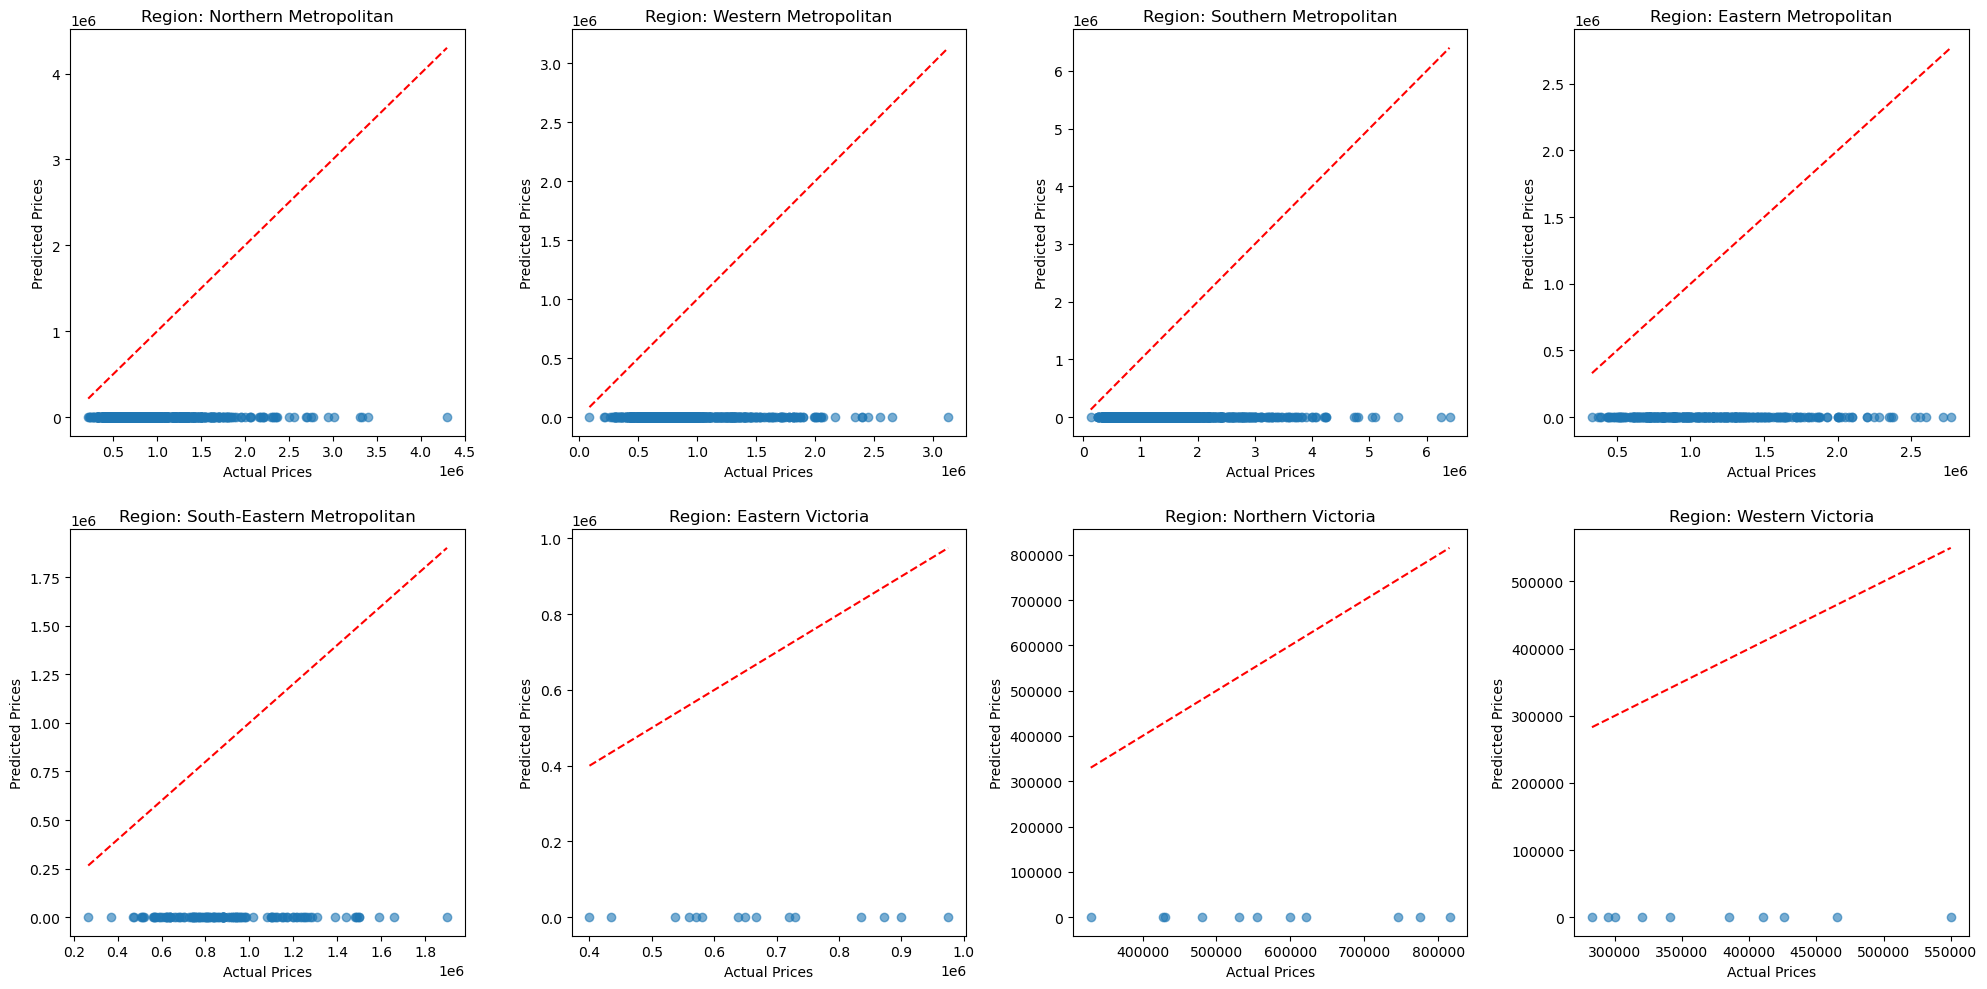

In [23]:
# Ensure results_random_split contains actual predictions for each region
# Example: results_random_split[region] = {'Predictions': y_pred, ...}

# Set up the plot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns for 8 regions
axes = axes.flatten()  # Flatten to iterate over axes

# Loop through each region and plot
for idx, (region, metrics) in enumerate(results_random_split.items()):
    ax = axes[idx]  # Get the current subplot
    
    # Extract actual and predicted prices
    region_df = region_data[region]
    train_data, test_data = random_split_region(region_df)  # Random split the region data
    y_test = test_data['Price'].values
    y_pred = metrics['Predictions']
    
    # Scatter plot: actual vs predicted
    ax.scatter(y_test, y_pred, alpha=0.6)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
    
    # Titles and labels
    ax.set_title(f"Region: {region}")
    ax.set_xlabel("Actual Prices")
    ax.set_ylabel("Predicted Prices")

# Adjust layout
plt.tight_layout()
plt.show()